In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, TFSegformerForSemanticSegmentation
import pandas as pd
import cv2
import numpy as np
# import albumentations as aug

In [2]:
WIDTH = 640
HEIGHT = 480

In [3]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "masks")

        print(self.img_dir)
        print(self.ann_dir)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Construct paths to the image and annotation
        image_path = os.path.join(self.img_dir, self.images[idx])
        annotation_path = os.path.join(self.ann_dir, self.annotations[idx])

        # Read the image and annotation using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        segmentation_map = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)

        # Convert segmentation map IDs to your dataset's specific class IDs
        num2id = {0: 0, 1: 29, 2: 150, 3: 179, 4: 76, 5: 105, 6: 226, 7: 255}
        converted_map = np.zeros_like(segmentation_map)
        for num, id_ in num2id.items():
            converted_map[segmentation_map == id_] = num
        segmentation_map = converted_map
        

        # Convert the OpenCV image to a PIL Image for the transformation
        image = Image.fromarray(image)
        segmentation_map = Image.fromarray(segmentation_map)

        # Resize the image and segmentation map to a fixed size, e.g., 640x480
        image = TF.resize(image, (HEIGHT, WIDTH))
        segmentation_map = TF.resize(segmentation_map, (HEIGHT, WIDTH), interpolation=TF.InterpolationMode.NEAREST)

        # Apply the transformations if any
        if self.transforms is not None:
            image = self.transforms(image)
        else:
            # Convert the PIL Image to a tensor (this also permutes dimensions to C x H x W)
            image = TF.to_tensor(image)

        # Convert the PIL Image back to a NumPy array if your processing pipeline requires it
        segmentation_map = np.array(segmentation_map)

        # Convert the segmentation map to a tensor
        segmentation_map = torch.tensor(segmentation_map, dtype=torch.long)


        # Prepare the return dictionary
        return_dict = {'pixel_values': image, 'labels': segmentation_map}

        # Include the filename in the return dictionary if not in training mode
        # Inside your method, after checking if not in training mode
        if not self.train:
            with Image.open(image_path) as img:
                width, height = img.size
            return_dict['filename'] = self.images[idx]
            return_dict['dim'] = (width, height)

        return return_dict

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.05),
    transforms.ToTensor(),
])

In [5]:
root_dir = 'SUIM'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
test_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

SUIM/train/images
SUIM/train/masks
SUIM/test/images
SUIM/test/masks


/home/cbm/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/models/segformer/feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(test_dataset))

Number of training examples: 1508
Number of validation examples: 110


In [7]:
encoded_inputs = train_dataset[0]
encoded_inputs["pixel_values"].shape

torch.Size([3, 480, 640])

In [8]:
encoded_inputs["labels"].shape

torch.Size([480, 640])

In [9]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [7, 7, 7,  ..., 3, 3, 3],
        [7, 7, 7,  ..., 3, 3, 3],
        [7, 7, 7,  ..., 3, 3, 3]])

In [10]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1, 3, 7])

In [11]:
mask = encoded_inputs["labels"].numpy()

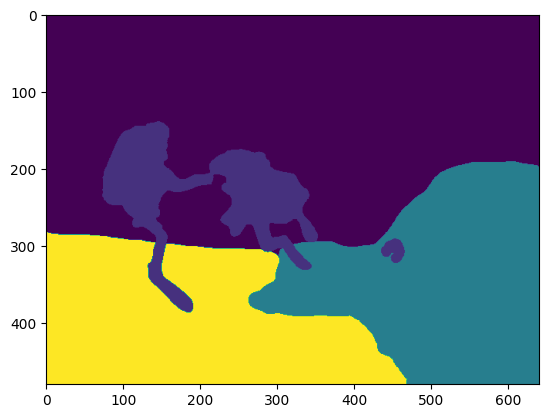

In [12]:
import matplotlib.pyplot as plt
plt.imshow(mask)

In [13]:
from torch.utils.data import DataLoader, random_split

total_size = len(train_dataset)
train_size = int(total_size * 0.8)  # 80% for training
validation_size = total_size - train_size  # 20% for validation

# Splitting the dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Creating DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(validation_dataset, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [14]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 480, 640])
labels torch.Size([4, 480, 640])


In [15]:
batch["labels"].shape

torch.Size([4, 480, 640])

In [16]:
id2label = {0: "BW", 1: "HD", 2: "PF", 3: "WR", 4: "RO", 5: "RI", 6: "FV", 7: "SR"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

In [17]:
model_checkpoint = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    reshape_last_stage=True,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode

In [18]:
optimizer = AdamW(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/home/cbm/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Model Initialized!


In [19]:
num_epochs = 100
for epoch in range(1, num_epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # pixel_values = pixel_values.permute(0, 3, 1, 2)

        # print(pixel_values.shape)
        # print(pixel_values.dtype)
        # print(labels.shape)
        # print(labels.dtype)

        # check that all labels values are within the range of the number of classes
        assert torch.all(labels < num_labels), "A label value is out of the range of the number of classes."

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 0) # we don't include the background class in the accuracy calculation
        # Check if the mask is not empty
        # print(labels)
        if mask.any():
            pred_labels = predicted[mask].detach().cpu().numpy()
            true_labels = labels[mask].detach().cpu().numpy()
            accuracy = accuracy_score(pred_labels, true_labels)
        else:
            print("Warning: No valid labels found for accuracy calculation.")
            accuracy = 0
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 0) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/302 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4000026117013314         Train Loss: 1.4526835932636892         Val Pixel-wise accuracy: 0.4760756915053216         Val Loss: 1.4138463131691281
Epoch: 2


  0%|          | 0/302 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4292947209464326         Train Loss: 1.3797450213637572         Val Pixel-wise accuracy: 0.49368064295049596         Val Loss: 1.326500065232578
Epoch: 3


  0%|          | 0/302 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.436096300180654         Train Loss: 1.342796289368181         Val Pixel-wise accuracy: 0.3198694627975646         Val Loss: 1.390843592976269
Epoch: 4


  0%|          | 0/302 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4435376986802465         Train Loss: 1.3282065602722546         Val Pixel-wise accuracy: 0.42799804424414273         Val Loss: 1.2766675055027008
Epoch: 5


  0%|          | 0/302 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.4489081032221531         Train Loss: 1.3024005116216395         Val Pixel-wise accuracy: 0.502820806763961         Val Loss: 1.1977484343867553
Epoch: 6


  0%|          | 0/302 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(model.state_dict(), "suim_segformer.pth")

PREDICT IN TEST IMAGES

In [ ]:
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
id2label = {0: "BW", 1: "HD", 2: "PF", 3: "WR", 4: "RO", 5: "RI", 6: "FV", 7: "SR"}
palette = [[0, 0, 0], [0, 0, 255], [0, 255, 0], [0, 255, 255], [255, 0, 0], [255, 0, 255], [255, 255, 0], [255, 255, 255]]
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

In [ ]:
# Predict in test images
root_dir = 'SUIM'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    reshape_last_stage=True,
)

# Load the model weights
checkpoint = torch.load("suim_segformer.pth", map_location=device)
model.load_state_dict(checkpoint)

model = model.to(device)


In [ ]:
model.eval()

def rescale_image(image, new_shape):
    return cv2.resize(image, (new_shape[1], new_shape[0]), interpolation=cv2.INTER_NEAREST)

def get_predictions(predictions_numpy, batch):
    # Get the image sizes
    original_shape = batch['pixel_values'].shape[-2:]
    
    # Rescale the predictions to the original image size
    rescaled_predictions = [rescale_image(prediction, original_shape) for prediction in predictions_numpy]
    
    # Convert list of rescaled predictions to a NumPy array
    rescaled_predictions = np.array(rescaled_predictions)
    
    # Get the original images and labels
    images = batch['pixel_values'].cpu().numpy()
    images = images.transpose(0, 2, 3, 1)
    labels = batch['labels'].cpu().numpy()

    return images, labels, rescaled_predictions

# Plot the images, labels, and predictions
def plot_predictions(images, labels, predictions):
    fig, axs = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
    for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(label)
        axs[i, 1].set_title("Label")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(prediction)
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

def label_to_rgb(label, palette):
    # Create an empty image with 3 channels for RGB
    rgb_image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    
    # Map each label to its corresponding color
    for i, color in enumerate(palette):
        mask = (label == i)
        rgb_image[mask] = color
    
    return rgb_image

def convert_predictions_and_labels_to_rgb(labels, predictions, palette):
    labels_rgb = np.array([label_to_rgb(label, palette) for label in labels])
    predictions_rgb = np.array([label_to_rgb(prediction, palette) for prediction in predictions])
    return labels_rgb, predictions_rgb

all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch['pixel_values'].to(device)
        filenames = batch['filename']
        dims = batch['dim']

        widths, heights = dims
        widths_list = widths.tolist()
        heights_list = heights.tolist()
        dims_tuples = list(zip(widths_list, heights_list))
        
        # Get model predictions
        outputs = model(inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        
        # Move predictions to CPU and convert to numpy for further processing if necessary
        predictions_numpy = predicted_labels.cpu().numpy()

        # Process and plot predictions for the current batch
        images, labels, rescaled_predictions = get_predictions(predictions_numpy, batch)

        # Labels and predictions to RGB with palette
        labels_rgb, predictions_rgb = convert_predictions_and_labels_to_rgb(labels, rescaled_predictions, palette)

        for filename, prediction_rgb, dim in zip(filenames, predictions_rgb, dims_tuples):
            all_predictions.append((filename, prediction_rgb, dim))

# Reshape all predicitons to the original image size

# Save the predictions as .png images
output_dir = 'test_predictions_GT'
os.makedirs(output_dir, exist_ok=True)

for filename, prediction, dim in all_predictions:  # Adjusted to unpack filenames with predictions
    # Reshape prediction to the original image size
    prediction = cv2.resize(prediction, dim, interpolation=cv2.INTER_NEAREST)
    output_path = os.path.join(output_dir, filename)  # Use original filename
    cv2.imwrite(output_path, prediction)